# Imports

In [1]:
using DataFrames
using CSV
using MLJ
using Plots
using StatsBase

include("../../lib.jl")

ENV["LINES"]=30;

# Datasets

In [2]:
data = CSV.read("./data.csv")

,Class_Name,Left_Weight,Left_Distance,Right_Weight,Right_Distance
,String,Int64,Int64,Int64,Int64
1,B,1,1,1,1
2,R,1,1,1,2
3,R,1,1,1,3
4,R,1,1,1,4
5,R,1,1,1,5
6,R,1,1,2,1
7,R,1,1,2,2
8,R,1,1,2,3
9,R,1,1,2,4


In [3]:
describe(data)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,DataType
1,Class_Name,,B,,R,3,,String
2,Left_Weight,3.0,1,3.0,5,,,Int64
3,Left_Distance,3.0,1,3.0,5,,,Int64
4,Right_Weight,3.0,1,3.0,5,,,Int64
5,Right_Distance,3.0,1,3.0,5,,,Int64


Look at class labels to see if dataset is imbalanced

In [4]:
label_counts = countmap(data[:Class_Name])

Dict{String,Int64} with 3 entries:
  "B" => 49
  "L" => 288
  "R" => 288

In [5]:
collect(label_counts[i] / size(data)[1] for i in keys(label_counts))

3-element Array{Float64,1}:
 0.0784
 0.4608
 0.4608

Get data ready for training

In [6]:
coerce!(data, :Class_Name=>Multiclass,
              :Left_Weight=>Continuous,
              :Right_Weight=>Continuous,
              :Left_Distance=>Continuous,
              :Right_Distance=>Continuous)
schema(data)

┌────────────────┬─────────────────────────────────┬───────────────┐
│ _.names        │ _.types                         │ _.scitypes    │
├────────────────┼─────────────────────────────────┼───────────────┤
│ Class_Name     │ CategoricalValue{String,UInt32} │ Multiclass{3} │
│ Left_Weight    │ Float64                         │ Continuous    │
│ Left_Distance  │ Float64                         │ Continuous    │
│ Right_Weight   │ Float64                         │ Continuous    │
│ Right_Distance │ Float64                         │ Continuous    │
└────────────────┴─────────────────────────────────┴───────────────┘
_.nrows = 625


In [7]:
y, X = unpack(data, ==(:Class_Name), colname->true)

(CategoricalValue{String,UInt32}["B", "R", "R", "R", "R", "R", "R", "R", "R", "R"  …  "L", "L", "L", "L", "L", "L", "L", "L", "L", "B"], 625×4 DataFrame
│ Row │ Left_Weight │ Left_Distance │ Right_Weight │ Right_Distance │
│     │ Float64     │ Float64       │ Float64      │ Float64        │
├─────┼─────────────┼───────────────┼──────────────┼────────────────┤
│ 1   │ 1.0         │ 1.0           │ 1.0          │ 1.0            │
│ 2   │ 1.0         │ 1.0           │ 1.0          │ 2.0            │
│ 3   │ 1.0         │ 1.0           │ 1.0          │ 3.0            │
│ 4   │ 1.0         │ 1.0           │ 1.0          │ 4.0            │
│ 5   │ 1.0         │ 1.0           │ 1.0          │ 5.0            │
│ 6   │ 1.0         │ 1.0           │ 2.0          │ 1.0            │
│ 7   │ 1.0         │ 1.0           │ 2.0          │ 2.0            │
│ 8   │ 1.0         │ 1.0           │ 2.0          │ 3.0            │
│ 9   │ 1.0         │ 1.0           │ 2.0          │ 4.0            │
│ 10  │

Partition train and test data accoring to class labels

In [8]:
# data to use when trying to fit a single validation set
train, test = partition(eachindex(y), 0.7, shuffle=true, rng=145) # gives 70:30 split

([466, 234, 200, 327, 30, 75, 307, 267, 383, 247  …  96, 397, 91, 319, 259, 222, 614, 323, 563, 110], [622, 178, 249, 228, 345, 274, 454, 136, 550, 393  …  554, 241, 155, 101, 317, 113, 484, 130, 471, 348])

In [9]:
train_counts = countmap(data[train,:Class_Name])
collect(train_counts[i] / size(train)[1] for i in keys(train_counts))

3-element Array{Float64,1}:
 0.0821917808219178
 0.4817351598173516
 0.4360730593607306

In [10]:
test_counts = countmap(data[test,:Class_Name])
collect(test_counts[i] / size(test)[1] for i in keys(test_counts))

3-element Array{Float64,1}:
 0.06951871657754011
 0.4117647058823529
 0.5187165775401069

# Five Learning Algorithms

* Decision trees with some form of pruning
* Neural networks
* Boosting
* Support Vector Machines
* k-nearest neighbors


##### Testing
* Implement the algorithms
* Design two *interesting* classification problems. For the purposes of this assignment, a classification problem is just a set of training examples and a set of test examples.

In [11]:
models(matching(X,y))

42-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = AdaBoostClassifier, package_name = ScikitLearn, ... )
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BaggingClassifier, package_name = ScikitLearn, ... )
 (name = BayesianLDA, package_name = MultivariateStats, ... )
 (name = BayesianLDA, package_name = ScikitLearn, ... )
 (name = BayesianQDA, package_name = ScikitLearn, ... )
 (name = BayesianSubspaceLDA, package_name = MultivariateStats, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DecisionTreeClassifier, package_name = DecisionTree, ... )
 (name = DeterministicConstantClassifier, package_na

In [12]:
@load SVMClassifier

SVMClassifier(
    C = 1.0,
    kernel = "rbf",
    degree = 3,
    gamma = "auto",
    coef0 = 0.0,
    shrinking = true,
    tol = 0.001,
    cache_size = 200,
    max_iter = -1,
    decision_function_shape = "ovr",
    random_state = nothing) @018

### Support Vector Machines
* This should be done in such a way that you can swap out kernel functions. I'd like to see at least two.

In [13]:
svm_model = SVMClassifier(kernel="linear")
svm_mach = machine(svm_model, X, y)
fit!(svm_mach, rows=train, verbosity=2)
svm_acc = evaluate!(svm_mach, resampling=CV(shuffle=true), measure=[accuracy], 
                        verbosity=1)

┌ Info: Training Machine{SVMClassifier} @858.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Evaluating over 6 folds: 100%[=========================] Time: 0:00:01


┌───────────┬───────────────┬────────────────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                                 │
├───────────┼───────────────┼────────────────────────────────────────────┤
│ accuracy  │ 0.917         │ [0.924, 0.875, 0.904, 0.952, 0.923, 0.923] │
└───────────┴───────────────┴────────────────────────────────────────────┘
_.per_observation = [missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [14]:
svm_model = SVMClassifier(kernel="sigmoid")
svm_mach = machine(svm_model, X, y)
fit!(svm_mach, rows=train, verbosity=2)
svm_acc = evaluate!(svm_mach, resampling=CV(shuffle=true), measure=[accuracy], 
                        verbosity=1)

┌ Info: Training Machine{SVMClassifier} @283.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Evaluating over 6 folds: 100%[=========================] Time: 0:00:00


┌───────────┬───────────────┬───────────────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                                │
├───────────┼───────────────┼───────────────────────────────────────────┤
│ accuracy  │ 0.43          │ [0.39, 0.452, 0.452, 0.413, 0.423, 0.452] │
└───────────┴───────────────┴───────────────────────────────────────────┘
_.per_observation = [missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [15]:
svm_model = SVMClassifier(kernel="rbf")
svm_mach = machine(svm_model, X, y)
fit!(svm_mach, rows=train, verbosity=2)
svm_acc = evaluate!(svm_mach, resampling=CV(shuffle=true), measure=[accuracy], 
                        verbosity=1)

┌ Info: Training Machine{SVMClassifier} @871.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Evaluating over 6 folds: 100%[=========================] Time: 0:00:00


┌───────────┬───────────────┬────────────────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                                 │
├───────────┼───────────────┼────────────────────────────────────────────┤
│ accuracy  │ 0.89          │ [0.829, 0.885, 0.933, 0.904, 0.894, 0.894] │
└───────────┴───────────────┴────────────────────────────────────────────┘
_.per_observation = [missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


Poly Degree 2 took a long wall clock time

In [16]:
svm_model = SVMClassifier(kernel="poly", degree=2)
svm_mach = machine(svm_model, X, y)
fit!(svm_mach, rows=train, verbosity=2)
svm_acc = evaluate!(svm_mach, resampling=CV(shuffle=true), measure=[accuracy], 
                        verbosity=1)

┌ Info: Training Machine{SVMClassifier} @345.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Evaluating over 6 folds: 100%[=========================] Time: 0:00:00


┌───────────┬───────────────┬────────────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                             │
├───────────┼───────────────┼────────────────────────────────────────┤
│ accuracy  │ 0.986         │ [0.99, 0.981, 1.0, 0.971, 0.99, 0.981] │
└───────────┴───────────────┴────────────────────────────────────────┘
_.per_observation = [missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


Can't use crossentropy because it is a probabilistic concept, and SVM doesn't do probabilities?

### GridSearch / RandomSearch

Use `linear` and `rbf`: 
* `linear` which has high bias
* `rbf` which has high variance

##### First look at `linear`

In [17]:
svm_linear_model = SVMClassifier(kernel="linear", cache_size=1000)
svm_linear_mach = machine(svm_linear_model, X, y)

Machine{SVMClassifier} @160 trained 0 times.
  args: 
    1:	Source @620 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @542 ⏎ `AbstractArray{Multiclass{3},1}`


In [18]:
# r1 = range(svm_linear_model, :C, lower=5*10^-6, upper=5*10^4, scale=:log10)
r1 = range(svm_linear_model, :C, lower=5*10^-3, upper=5*10^3, scale=:log10)
curve = learning_curve(svm_linear_mach, 
                        range=r1,
                        resampling=CV(), 
                        measure=accuracy, 
                        acceleration=CPUProcesses(),
                        resolution=30)

┌ Info: Training Machine{DeterministicTunedModel{Grid,…}} @502.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 30 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 30 metamodels: 100%[=========================] Time: 0:00:07


(parameter_name = "C",
 parameter_scale = :log10,
 parameter_values = [0.004999999999999999, 0.008051310137804695, 0.012964718987023333, 0.020876594682802, 0.033616787682496686, 0.05413183669370272, 0.0871664411099994, 0.14036081019705884, 0.22601768281801213, 0.3639476921991575  …  68.69118979416315, 110.61081455352239, 178.11239451312218, 286.807625522434, 461.8354285936932, 743.6760536467558, 1197.5133099937427, 1928.3102105817359, 3105.0847094578075, 4999.999999999999],
 measurements = [0.8751831501831502, 0.8655677655677656, 0.8896062271062272, 0.8623626373626373, 0.8687728937728937, 0.8671703296703296, 0.8751831501831502, 0.8751373626373627, 0.8799450549450549, 0.8928113553113554  …  0.9167277167277167, 0.9167277167277167, 0.9167277167277167, 0.9167277167277167, 0.9167277167277167, 0.9167277167277167, 0.9167277167277167, 0.9167277167277167, 0.9167277167277167, 0.9167277167277167],)

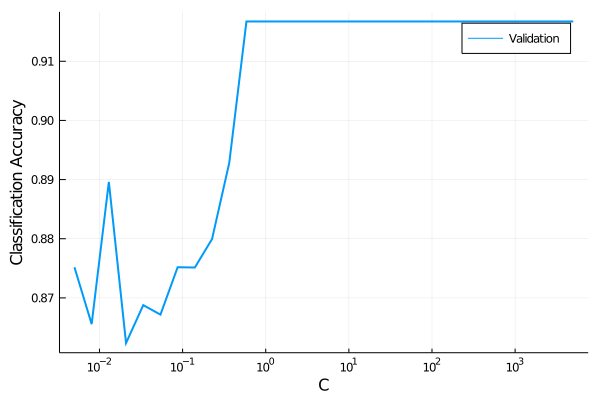

In [19]:
plot(curve.parameter_values,
     curve.measurements,
     xscale=curve.parameter_scale,
     xlab=curve.parameter_name,
     ylab="Classification Accuracy",
     label="Validation", lw=2)

In [20]:
a = round(maximum(curve.measurements), digits=5)

0.91673

In [21]:
best_C = curve.parameter_values[argmax(curve.measurements)]

0.58605114876674

##### Second look at `rbf`

In [22]:
r1 = range(Float64, :C, lower=5*10^3, upper=5*10^10, scale=:log10)
r2 = range(Float64, :gamma, lower=10^-7, upper=10^1, scale=:log10)

MLJBase.NumericRange(Float64, :gamma, ... )

In [23]:
svm_rbf_model = SVMClassifier(kernel="rbf", cache_size=1000)
self_tuning_svm_model = TunedModel(model=svm_rbf_model,
                                    tuning=Grid(goal=100),
                                    resampling=CV(), 
                                    measure=accuracy,
                                    acceleration=CPUThreads(),
                                    range=[r1,r2])

DeterministicTunedModel(
    model = SVMClassifier(
            C = 1.0,
            kernel = "rbf",
            degree = 3,
            gamma = "auto",
            coef0 = 0.0,
            shrinking = true,
            tol = 0.001,
            cache_size = 1000,
            max_iter = -1,
            decision_function_shape = "ovr",
            random_state = nothing),
    tuning = Grid(
            goal = 100,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = CV(
            nfolds = 6,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = accuracy(),
    weights = nothing,
    operation = MLJModelInterface.predict,
    range = MLJBase.NumericRange{Float64,MLJBase.Bounded,Symbol}[NumericRange{Float64,…} @483, NumericRange{Float64,…} @926],
    train_best = true,
    repeats = 1,
    n = nothing,
    acceleration = CPUThreads{Int64}(1),
    acceleration_resampling = CPU1{Nothing}(nothing),
 

In [24]:
self_tuning_svm_mach = machine(self_tuning_svm_model, X, y)

Machine{DeterministicTunedModel{Grid,…}} @379 trained 0 times.
  args: 
    1:	Source @949 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @290 ⏎ `AbstractArray{Multiclass{3},1}`


In [25]:
z = fit!(self_tuning_svm_mach, rows=train)

┌ Info: Training Machine{DeterministicTunedModel{Grid,…}} @379.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 100 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 100 metamodels: 100%[=========================] Time: 0:00:27


Machine{DeterministicTunedModel{Grid,…}} @379 trained 1 time.
  args: 
    1:	Source @949 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @290 ⏎ `AbstractArray{Multiclass{3},1}`


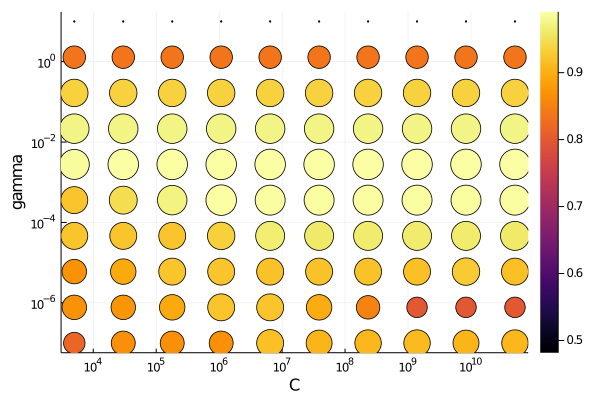

In [26]:
plot(self_tuning_svm_mach)

In [27]:
best_rbf = fitted_params(self_tuning_svm_mach)
best_rbf

(best_model = SVMClassifier @667,
 best_fitted_params = (support = Int32[18, 94, 130, 156, 158, 178, 192, 193, 253, 262  …  321, 400, 31, 57, 82, 199, 234, 297, 331, 428],
                       support_vectors = [2.0 2.0 1.0 4.0; 2.0 4.0 4.0 2.0; … ; 5.0 1.0 2.0 3.0; 1.0 4.0 5.0 1.0],
                       n_support = Int32[18, 7, 8],
                       dual_coef = [0.0 0.0 … -4723.578559351571 -2637.435373177888; 34972.13829424317 4367.650353374728 … -2831.9507510131443 -0.0],
                       coef = nothing,
                       intercept = [-28.191953024809585, 2.3735178195801114, -4.1772109533697],
                       fit_status = 0,
                       classes = UInt32[0x00000001, 0x00000002, 0x00000003],),)

In [28]:
best_rbf.best_model

SVMClassifier(
    C = 8.3405026860002775e9,
    kernel = "rbf",
    degree = 3,
    gamma = 0.0027825594022071257,
    coef0 = 0.0,
    shrinking = true,
    tol = 0.001,
    cache_size = 1000,
    max_iter = -1,
    decision_function_shape = "ovr",
    random_state = nothing) @667

In [29]:
best_loss = round(z.report.best_result.measurement[1],digits=5)

0.99087

In [30]:
# fn = "Figures/LearningCurve_DT_merge_purity_thresh:$(best_mpt)_loss:$(best_loss)"
# png(replace(fn,'.' => ','))

##### More fitting

In [31]:
best_linear_model = SVMClassifier(kernel="linear", C = best_C)
svm_mach = machine(best_linear_model, X, y)
lf = fit!(svm_mach, rows=train, verbosity=2)
svm_acc = evaluate!(svm_mach, resampling=CV(shuffle=true), measure=[accuracy], 
                        verbosity=1)

┌ Info: Training Machine{SVMClassifier} @731.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Evaluating over 6 folds: 100%[=========================] Time: 0:00:00


┌───────────┬───────────────┬────────────────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                                 │
├───────────┼───────────────┼────────────────────────────────────────────┤
│ accuracy  │ 0.917         │ [0.924, 0.981, 0.913, 0.933, 0.923, 0.827] │
└───────────┴───────────────┴────────────────────────────────────────────┘
_.per_observation = [missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [32]:
best_rbf_model = SVMClassifier(kernel="rbf", C=best_rbf.best_model.C, gamma=best_rbf.best_model.gamma)
svm_mach = machine(best_rbf_model, X, y)
fit!(svm_mach, rows=train, verbosity=2)
svm_acc = evaluate!(svm_mach, resampling=CV(shuffle=true), measure=[accuracy], 
                        verbosity=1)

┌ Info: Training Machine{SVMClassifier} @676.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Evaluating over 6 folds: 100%[=========================] Time: 0:00:00


┌───────────┬───────────────┬──────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                       │
├───────────┼───────────────┼──────────────────────────────────┤
│ accuracy  │ 0.997         │ [1.0, 1.0, 1.0, 1.0, 1.0, 0.981] │
└───────────┴───────────────┴──────────────────────────────────┘
_.per_observation = [missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


### Learning Curves

In [33]:
data_schedule, training_losses, valid_losses = learn_curve(best_linear_model, X[train,:], y[train])

(d, train_metric, valid_metric) = (10, 1.0, 0.7272727272727273)
(d, train_metric, valid_metric) = (15, 0.9333333333333333, 0.7159090909090908)
(d, train_metric, valid_metric) = (20, 0.95, 0.8068181818181819)
(d, train_metric, valid_metric) = (25, 0.96, 0.7840909090909091)
(d, train_metric, valid_metric) = (30, 0.9666666666666667, 0.7840909090909091)
(d, train_metric, valid_metric) = (35, 0.8857142857142857, 0.8295454545454546)
(d, train_metric, valid_metric) = (40, 0.9, 0.8295454545454546)
(d, train_metric, valid_metric) = (45, 0.8888888888888888, 0.8181818181818181)
(d, train_metric, valid_metric) = (50, 0.88, 0.7840909090909091)
(d, train_metric, valid_metric) = (55, 0.9090909090909091, 0.8295454545454546)
(d, train_metric, valid_metric) = (60, 0.9166666666666666, 0.8295454545454546)
(d, train_metric, valid_metric) = (65, 0.9076923076923077, 0.8409090909090909)
(d, train_metric, valid_metric) = (70, 0.9142857142857143, 0.8181818181818181)
(d, train_metric, valid_metric) = (75, 0.92, 

(10:5:350, Any[1.0, 0.9333333333333333, 0.95, 0.96, 0.9666666666666667, 0.8857142857142857, 0.9, 0.8888888888888888, 0.88, 0.9090909090909091  …  0.921311475409836, 0.9225806451612903, 0.9238095238095239, 0.921875, 0.92, 0.9212121212121213, 0.9194029850746268, 0.9205882352941177, 0.9217391304347826, 0.9228571428571428], Any[0.7272727272727273, 0.7159090909090908, 0.8068181818181819, 0.7840909090909091, 0.7840909090909091, 0.8295454545454546, 0.8295454545454546, 0.8181818181818181, 0.7840909090909091, 0.8295454545454546  …  0.9204545454545454, 0.9204545454545454, 0.9204545454545454, 0.9204545454545454, 0.9204545454545454, 0.9204545454545454, 0.9204545454545454, 0.9204545454545454, 0.9204545454545454, 0.9204545454545454])

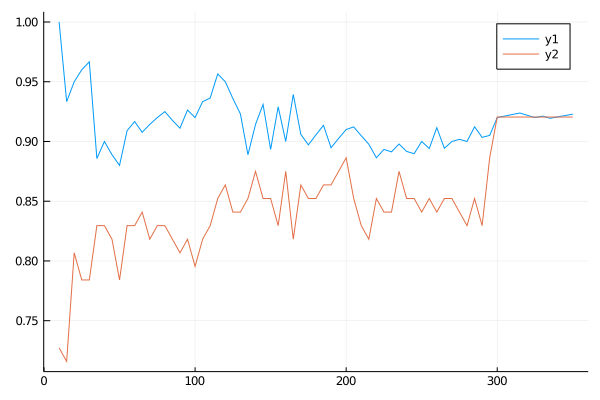

In [34]:
plot(data_schedule, training_losses)
plot!(data_schedule, valid_losses)

In [35]:
data_schedule, training_losses, valid_losses = learn_curve(best_rbf_model, X[train,:], y[train])

(d, train_metric, valid_metric) = (10, 1.0, 0.7159090909090908)
(d, train_metric, valid_metric) = (15, 1.0, 0.6818181818181819)
(d, train_metric, valid_metric) = (20, 1.0, 0.7954545454545454)
(d, train_metric, valid_metric) = (25, 1.0, 0.8181818181818181)
(d, train_metric, valid_metric) = (30, 1.0, 0.8181818181818181)
(d, train_metric, valid_metric) = (35, 1.0, 0.75)
(d, train_metric, valid_metric) = (40, 1.0, 0.7386363636363636)
(d, train_metric, valid_metric) = (45, 1.0, 0.75)
(d, train_metric, valid_metric) = (50, 1.0, 0.75)
(d, train_metric, valid_metric) = (55, 1.0, 0.7840909090909091)
(d, train_metric, valid_metric) = (60, 1.0, 0.7840909090909091)
(d, train_metric, valid_metric) = (65, 1.0, 0.8068181818181819)
(d, train_metric, valid_metric) = (70, 1.0, 0.8409090909090909)
(d, train_metric, valid_metric) = (75, 1.0, 0.8409090909090909)
(d, train_metric, valid_metric) = (80, 1.0, 0.8409090909090909)
(d, train_metric, valid_metric) = (85, 1.0, 0.8522727272727273)
(d, train_metric, 

(10:5:350, Any[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], Any[0.7159090909090908, 0.6818181818181819, 0.7954545454545454, 0.8181818181818181, 0.8181818181818181, 0.75, 0.7386363636363636, 0.75, 0.75, 0.7840909090909091  …  0.9659090909090909, 0.9659090909090909, 0.9772727272727273, 0.9886363636363636, 0.9886363636363636, 0.9886363636363636, 0.9886363636363636, 0.9886363636363636, 0.9886363636363636, 0.9886363636363636])

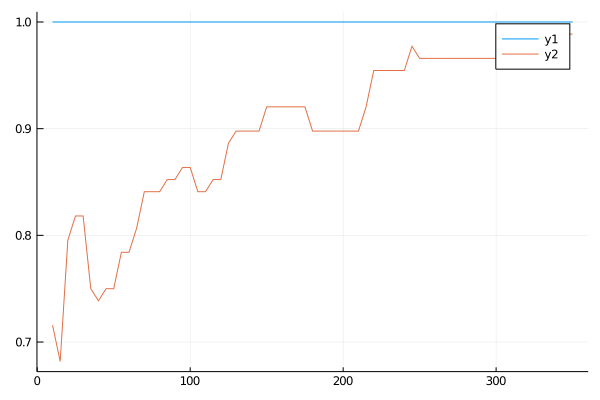

In [36]:
plot(data_schedule, training_losses)
plot!(data_schedule, valid_losses)

# Final Results

Linear SVM

In [37]:
final_svm = SVMClassifier(kernel="linear", C = best_C, cache_size=1000)

SVMClassifier(
    C = 0.58605114876674,
    kernel = "linear",
    degree = 3,
    gamma = "auto",
    coef0 = 0.0,
    shrinking = true,
    tol = 0.001,
    cache_size = 1000,
    max_iter = -1,
    decision_function_shape = "ovr",
    random_state = nothing) @967

In [38]:
Final_SVM = machine(final_svm, X, y)

Machine{SVMClassifier} @069 trained 0 times.
  args: 
    1:	Source @479 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @590 ⏎ `AbstractArray{Multiclass{3},1}`


In [39]:
fit!(Final_SVM, rows=train, verbosity=2)

┌ Info: Training Machine{SVMClassifier} @069.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


Machine{SVMClassifier} @069 trained 1 time.
  args: 
    1:	Source @479 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @590 ⏎ `AbstractArray{Multiclass{3},1}`


In [40]:
ŷ2 = MLJ.predict(Final_SVM, X[test,:]);

In [41]:
accuracy(ŷ2, y[test])

0.9037433155080214

In [42]:
confusion_matrix(ŷ2, y[test])

┌ Warning: The classes are un-ordered,
│ using order: ["B", "L", "R"].
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/measures/confusion_matrix.jl:87


              ┌─────────────────────────────────────────┐
              │              Ground Truth               │
┌─────────────┼─────────────┬─────────────┬─────────────┤
│  Predicted  │      B      │      L      │      R      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      B      │     10      │      7      │      5      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      L      │      2      │     68      │      1      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      R      │      1      │      2      │     91      │
└─────────────┴─────────────┴─────────────┴─────────────┘


RBF SVM

In [43]:
final_svm_rbf = best_rbf.best_model

SVMClassifier(
    C = 8.3405026860002775e9,
    kernel = "rbf",
    degree = 3,
    gamma = 0.0027825594022071257,
    coef0 = 0.0,
    shrinking = true,
    tol = 0.001,
    cache_size = 1000,
    max_iter = -1,
    decision_function_shape = "ovr",
    random_state = nothing) @667

In [44]:
Final_SVM = machine(final_svm, X, y)

Machine{SVMClassifier} @476 trained 0 times.
  args: 
    1:	Source @085 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @359 ⏎ `AbstractArray{Multiclass{3},1}`


In [45]:
fit!(Final_SVM, rows=train, verbosity=2)

┌ Info: Training Machine{SVMClassifier} @476.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


Machine{SVMClassifier} @476 trained 1 time.
  args: 
    1:	Source @085 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @359 ⏎ `AbstractArray{Multiclass{3},1}`


In [46]:
ŷ2 = MLJ.predict(Final_SVM, X[test,:]);

In [47]:
accuracy(ŷ2, y[test])

0.9037433155080214

In [48]:
confusion_matrix(ŷ2, y[test])

┌ Warning: The classes are un-ordered,
│ using order: ["B", "L", "R"].
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/measures/confusion_matrix.jl:87


              ┌─────────────────────────────────────────┐
              │              Ground Truth               │
┌─────────────┼─────────────┬─────────────┬─────────────┤
│  Predicted  │      B      │      L      │      R      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      B      │     10      │      7      │      5      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      L      │      2      │     68      │      1      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      R      │      1      │      2      │     91      │
└─────────────┴─────────────┴─────────────┴─────────────┘
